# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

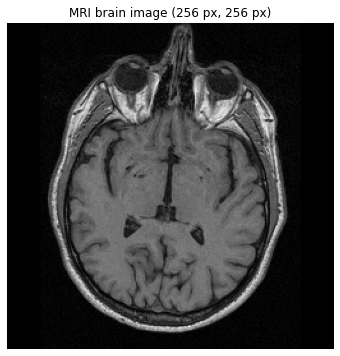

(256, 256)

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

brain_im.shape

### 1.2 Region growing (5pts)

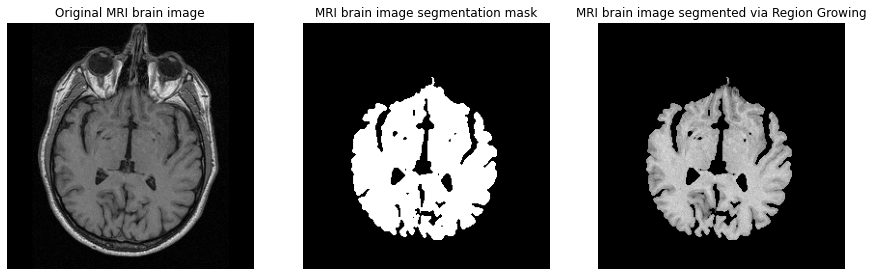

Number of pixels in brain: 15935


In [3]:
import cv2 as cv
import numpy as np

def get_neighbours_not_in_region(pixel, output):
    """
    Function returning a list containing the 8 neighbours of pixel which are not already segmented 
    in output (ignoring those neighbours which would fall out of the image boundaries).
    
    Args:
        pixel::[tuple]
            Tuple of form (line, col) containing the pixel we want to compute the neighbours of.
        output::[np.array]
            Output segmentation mask of same shape as original grayscale image.
    Returns:
        neighbours_not_in_region::[list]
            List of pixels (tuples of same form as pixel parameter), containing the neighbours of
            pixel parameter which are not already segmented in output and that are in image boundaries.
    """
    pixel_line , pixel_col  = pixel
    image_lines, image_cols = output.shape
    
    neighbours_not_in_region = []
    for delta_line in [-1, 0, +1]:
        neighbour_line = pixel_line + delta_line
        
        # If we are outside the image, skip these pixels.
        if neighbour_line < 0 or neighbour_line >= image_lines:
            continue
        
        for delta_col in [-1, 0, +1]:
            # If we are on current pixel, skip this pixel.
            if delta_line == 0 and delta_col == 0:
                continue
            
            neighbour_col = pixel_col + delta_col
            
            # If we are outside the image, skip these pixels.
            if neighbour_col < 0 or neighbour_col >= image_cols:
                continue
            
            # Add neighbour if not already in the region.
            neighbour = (neighbour_line, neighbour_col)
            if not output[neighbour]:
                neighbours_not_in_region.append(neighbour)
                
    return neighbours_not_in_region
    

def segment_region_growing(image, seed, threshold, neighbourhood_size):
    """
    Function returning a segmentation mask computed by region growing from seed.
    
    Args:
        image::[np.array]
            Input image on which we want to perform region growing.
        seed::[tuple]
            Tuple of form (line, col) containing the pixel we want to start growing the region from.
        threshold::[float]
            Threshold for deciding if new pixel is included in region.
        neighbourhood_size::[int]
            Size of the neighbourhood of current pixel on which to calculate the mean. Must be >0 and
            if even number is given, neighbourhood_size+1 is used instead.
    Returns:
        output::[np.array]
            Output segmentation mask performed by region growing with seed as starting pixel.
    """
    assert(neighbourhood_size >= 0)
    delta_lower = -(neighbourhood_size//2)
    delta_upper = +(neighbourhood_size//2)+1
        
    output = np.zeros_like(image, dtype = np.bool_)
    
    pixels_to_treat = [seed]
    
    while pixels_to_treat:
        current_pixel = pixels_to_treat[-1]
        pixels_to_treat.pop()
        
        output[current_pixel] = True
        
        for neighbour in get_neighbours_not_in_region(current_pixel, output):            
            neighbourhood_mean = float(np.mean(image[current_pixel[0]+delta_lower:current_pixel[0]+delta_upper, 
                                                     current_pixel[1]+delta_lower:current_pixel[1]+delta_upper]))
            
            if not output[neighbour] and abs(neighbourhood_mean - image[neighbour]) < threshold:
                pixels_to_treat.append(neighbour)
                
    return output
        
        
# Region Growing parameters.
seed      = (140, 140)
threshold = 4
neighbourhood_size = 1

# Filter parameters.
size_median_filter_image = 3
size_median_filter_mask  = 3
           

# Applying a median filter in order to reduce the noise while keeping the edges clear.
brain_median = cv.medianBlur(brain_im, size_median_filter_image)

# Segmenting.
mask = segment_region_growing(brain_median, seed, threshold, neighbourhood_size)

# Applying a median filter in order to close small holes in the mask.
mask = cv.medianBlur(mask.astype(np.uint8), size_median_filter_mask)


# Display Segmentated Brain.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image segmentation mask')
ax[1].axis('off')
ax[2].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[2].set_title('MRI brain image segmented via Region Growing')
ax[2].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

In [4]:
%%timeit
brain_median = cv.medianBlur(brain_im, size_median_filter_image)
mask = segment_region_growing(brain_median, seed, threshold, neighbourhood_size)
mask = cv.medianBlur(mask.astype(np.uint8), size_median_filter_mask)

1.14 s ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<b>DISCUSSION</b>
<br>
##### General comment on method
Generally region growing method has can seperate well regions from the seeds especially when seeds are contrasted. However some disadvantages includes a local range of view, not robust to noise, if seeds/pixels are not contrasted enough two regions could combine into one and sequential method. Here in our situation, the image at first glance does not seem very noisy but happens to still not be clean enough therefore we median pass filter the original image. The region we wish to segment is roughly a one-connected component (locallity) and the seeds and regions are contrasted enough.
##### Choice of params
Starting seed was chosen to be `within the brain region` (target region) the exact choice is arbitrary (<i>tell me if i'm wrong</i>). Threshold for the similarity criteria was `empirically picked` after multiple display of results. (<i>tell me if i'm wrong</i>)
##### Comment on results
Our segmented region occupies in total an area of `15935 pixels`. Most shapes and curves within the brain region were segmented properly. However, some parts the brain were not included in the target region due to its neighbourhood being of lower values and thus some dark region within the brain has a larger area than it should (its bounds oversteps).
##### Comparison to other methods
- Time-wise (sequential)
- etc...

### 1.3 Contour detection (5pts)

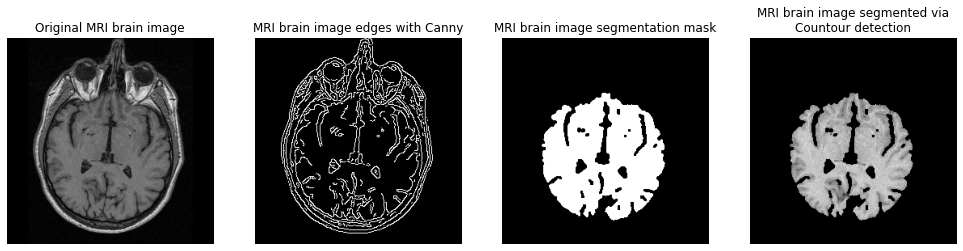

Number of pixels in brain: 15538


In [5]:
def segment_countour_detection(image, canny_threshold_low, canny_threshold_high, dilation_structuring_element, seed):
    """
    Function returning the results of the Canny Edges detector and the image after
    doing the connected component inside the brain to isolate it.
    
    Args:
        image::[np.array]
            Input image on which we perform contour edge detection.
        canny_threshold_low::[float] 
            Value of the low threshold for Canny edge detector's hysteresis.
        canny_threshold_high::[float]
            Value of the high threshold for Canny edge detector's hysteresis.
        dilation_structuring_element::[np.array]
            Kernel used to dilate and connected the edges made by Canny edge detector.
        seed::[tuple]
            Tuple of form (line, col) containing a pixel we know is in the brain.
    Returns: 
        canny_detector::[np.array]:
            Image output of the Canny detector.
        mask::[np.array]:
            Output segmentation mask of the brain.
    """
    # Edge detection.
    canny_detector = cv.Canny(brain_median, canny_threshold_low, canny_threshold_high)
    
    # In order to segment the brain, we must first close the edges.
    # To do so, we dilate the image edges.
    dilated = cv.dilate(canny_detector, dilation_structuring_element)
    
    # Segmenting with cv.connectedComponent requires background of image to be black and 
    # foreground to be white. Thus we take the negative of the image.
    dilated = np.where(dilated > 0, 0, 255).astype(np.uint8)

    # Segmenting.
    _, segmented = cv.connectedComponents(dilated)
    mask         = segmented == segmented[seed]

    # Dilation of segmented area to counteract previous dilation of borders.
    mask = cv.dilate(mask.astype(np.uint8), kernel)

    return canny_detector, mask
    
    
# Canny Edge Detector Parameters.
threshold_low  = 50
threshold_high = 90

# Filter parameters.
size_median_filter_image = 3

# Dilation structuring element.
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))

# Pixel in brain.
seed = (140, 140)


## Applying a median filter in order to reduce the noise while keeping the edges clear.
brain_median = cv.medianBlur(brain_im, size_median_filter_image)

# Segmenting.
canny_detector, mask = segment_countour_detection(brain_im, threshold_low, threshold_high, kernel, seed)

# Closing to remove small holes.
mask = cv.morphologyEx(mask.astype(np.uint8), cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (3,3)))


# Display Segmented Brain
fig, ax = plt.subplots(1, 4, figsize=(17, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(canny_detector, cmap='gray')
ax[1].set_title('MRI brain image edges with Canny')
ax[1].axis('off')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('MRI brain image segmentation mask')
ax[2].axis('off')
ax[3].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[3].set_title('MRI brain image segmented via\nCountour detection')
ax[3].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

In [6]:
%%timeit
brain_median = cv.medianBlur(brain_im, size_median_filter_image)
canny_detector, mask = segment_countour_detection(brain_im, threshold_low, threshold_high, kernel, seed)
mask = cv.morphologyEx(mask.astype(np.uint8), cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (3,3)))

2.82 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<b>DISCUSSION</b>
<br>
##### General comment on method
Canny is most of times robust and since it is parametrized, it is possible to optimize for a specific image, it also conserves local pattern. In our case we see that from general shape to details the target edges are extracted. We then apply morphologies and connected components to obtain only the region containing our seed. 
##### Choice of params
The thresholds are picked after investigating the general pixel `intensity of the brain region` that we are interested in. Similarly to the previous method, the seed for segmentation was picked arbitrarily.
##### Comment on results
The general shape is well segmented and most dark zones within the brain are not over-estimated. However, due to using morphology (cross kernels), smaller pattern of the brain are not segmented, and larger parts are also ommited due to the connected components-way of linking objects inside the detected contour.
##### Comparison to other methods

### 1.4 Additional method (5pts)

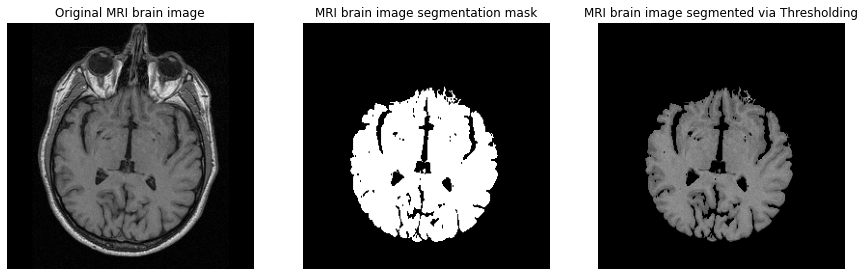

Number of pixels in brain: 16734


In [7]:
def segment_thresholding(image, threshold_low, threshold_high, seed):
    """
    Function returning a segmentation mask computed by thresholding the
    input image between threshold_low and threshold_high and keeping only
    the region containing seed.
    
    Args:
        image::[np.array]
            Input image on which we perform segmentation.
        threshold_low::[float] 
            Value of the low grayscale threshold for image.
        threshold_high::[float]
            Value of the high grayscale threshold for image.
        seed::[tuple]
            Tuple of form (line, col) containing a pixel we know is in the brain.
    Returns:
        mask::[np.array]:
            Output segmentation mask of the brain.
    """

    # Carefully chosen thresholding.
    thresholded = np.logical_and(brain_im > threshold_low, brain_im < threshold_high).astype(np.uint8)

    # Segmenting.
    _, labels   = cv.connectedComponents(thresholded)
    mask        = (labels == labels[seed]).astype(np.uint8)
    
    return mask


# Thresholding parameters.
threshold_low  = 50
threshold_high = 95

# Pixel in brain.
seed = (140, 140)


# Segmenting.
mask = segment_thresholding(brain_im, threshold_low, threshold_high, seed)

# Closing to remove small holes.
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (1,2)))


# Display Segmentated Brain.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image segmentation mask')
ax[1].axis('off')
ax[2].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[2].set_title('MRI brain image segmented via Thresholding')
ax[2].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

In [8]:
%%timeit
mask = segment_thresholding(brain_im, threshold_low, threshold_high, seed)
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (1,2)))

3.02 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<i>Connected components with stats </i>
<br>
<b>DISCUSSION</b>
<br>
##### General comment on method
Similar to Canny but using thresholding, still a edge detection method.
##### Choice of params
Threshold parameters found using histogram of colors matching brain region.
##### Comment on results
General shape was segmented yet details are not kept. Closing does close a bit of horizontal lines on the side of the brain, but that's acceptable. The area of the brain region is thus likely to be over-estimated
##### Comparison to other methods

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [9]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


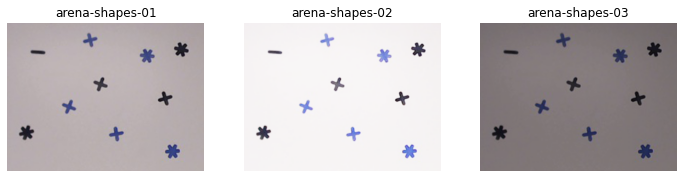

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

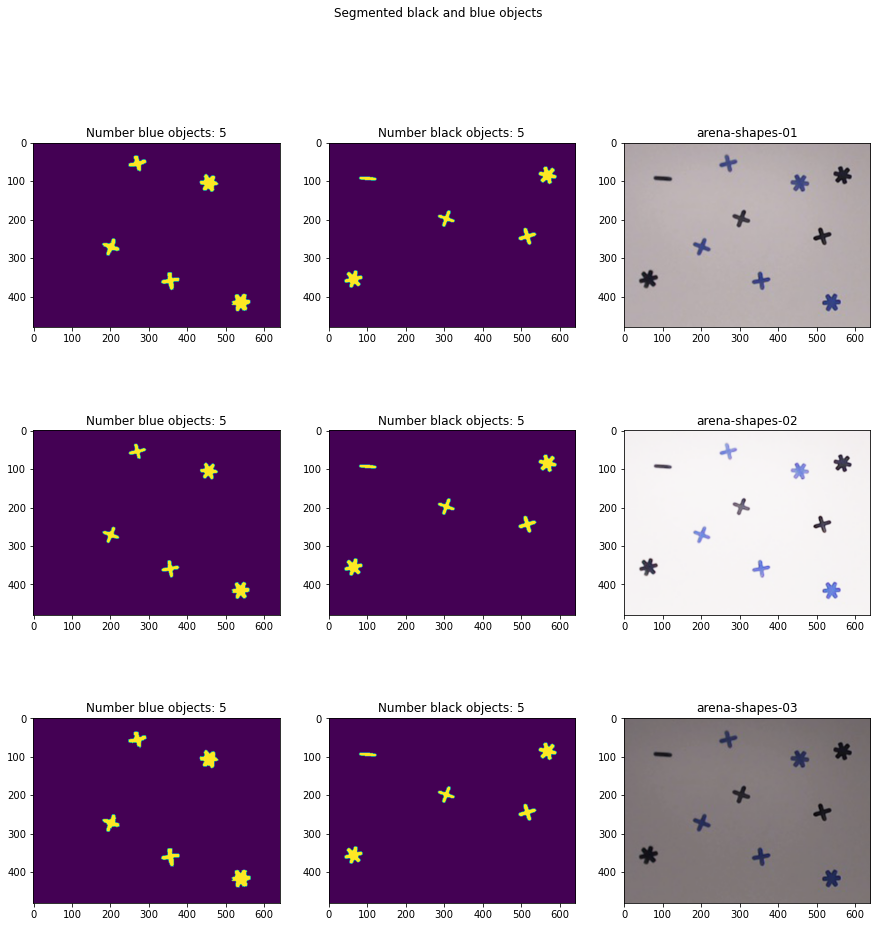

In [59]:
def detect_same_object(component1, component2, tolerance):
    distance = np.linalg.norm(component1["centroid"] - component2["centroid"])
    radius_component1 = (component1["width"] + component1["height"]) / 4 
    radius_component2 = (component2["width"] + component2["height"]) / 4 

    if distance <= radius_component1 + tolerance or distance <= radius_component2 + tolerance:
        return True
    
    return False

def get_components_from_mask(mask, tolerance = 10, min_size = 50):
    """
    desc: from mask specific to a color find objects of that color
    param: mask::[np.array(2d)]
           thresh::[int] | minimum pixel for an object (arbitrary will find better later)
           verbose::[bool]
    output: binary array::[np.array(2d)]
    """
    
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask)
    
    # Merging close components that belong to same object, skipping background labeled 0.
    new_labels = {}
    for component1 in range(1, num_labels):
        parameters1 = {"centroid": np.array(centroids[component1]), "width": stats[component1, cv.CC_STAT_WIDTH], "height": stats[component1, cv.CC_STAT_HEIGHT]}
        for component2 in range(component1 + 1, num_labels):
            parameters2 = {"centroid": np.array(centroids[component2]), "width": stats[component2, cv.CC_STAT_WIDTH], "height": stats[component2, cv.CC_STAT_HEIGHT]}
            if detect_same_object(parameters1, parameters2, tolerance):
                new_labels[component2] = component1
    
    # Solves conflicts caused by values in dictionary which are also keys.
    key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    while key_value_conflicts:
        for conflict in key_value_conflicts:
            new_labels[conflict] = new_labels[new_labels[conflict]]
        key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    
    # Merges close components that belong to same object.
    for old_component, new_component in new_labels.items():
        labels[labels == old_component] = new_component
    
    # Removes too small groups (merges them with background).
    unique, counts = np.unique(labels, return_counts=True)
    for component, n_pixels in zip(unique, counts):
        if n_pixels < min_size:
            labels[labels == component] = 0
           
    # Creates mask from components not in background.
    mask = labels > 0
        
    return len(np.unique(labels[mask])), mask


def get_blue_black_masks(image):
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    image_hsv[:,:,2] = cv.equalizeHist(image_hsv[:,:,2])
    
    blue_mask  = cv.inRange(image_hsv, (90, 50, 4), (135, 255, 255))
    black_mask = cv.inRange(image_hsv, (0, 0, 0), (180, 255, 3))
    
    return blue_mask, black_mask


fig, ax = plt.subplots(3, 3, figsize = (15,15))
fig.suptitle('Segmented black and blue objects')
for idx, (image, name) in enumerate(zip(images, im_names), start=0):
    
    blue_mask, black_mask = get_blue_black_masks(image)
    
    n_objects_blue , mask_objects_blue  = get_components_from_mask(blue_mask)
    n_objects_black, mask_objects_black = get_components_from_mask(black_mask)

    ax[idx, 0].imshow(mask_objects_blue)
    ax[idx, 0].set_title(f'Number blue objects: {n_objects_blue}')
    ax[idx, 1].imshow(mask_objects_black)
    ax[idx, 1].set_title(f'Number black objects: {n_objects_black}')
    ax[idx, 2].imshow(images[idx])
    ax[idx, 2].set_title(name)

In [57]:
%%timeit
image_hsv = cv.cvtColor(images[0], cv.COLOR_RGB2HSV)
image_hsv[:,:,2] = cv.equalizeHist(image_hsv[:,:,2])

blue_mask  = cv.inRange(image_hsv, (90, 50, 5), (135, 255, 255))
n_objects_blue, mask_objects_blue  = get_components_from_mask(blue_mask)

30.4 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<b>DISCUSSION</b>
<br>
##### General comment on method
Thresholding + <i>comments on normalization of intensity</i> then use connected components and reject componenents with small pixel area.
##### Choice of params
Color for blue and black objects mask empirically found (after histogram equalization)
##### Comment on results
The counting of objects are correct however it is linked the sample having strong contrast and roughly same size objects.
##### Comparison to other methods

### 2.3 Total area (in pixels) of each color (5 pts)

In [58]:
# Add your implementation and discussion
def color_area1(image):
    """ 
    desc: find the area occupied by each colors
    param: image::[np.array(2d)]
    output: (# blue pixels,# black pixels)::[tuple(int,int)]
    """
    
    blue_mask, black_mask = get_blue_black_masks(image)

    _, mask_objects_blue  = get_components_from_mask(blue_mask)
    _, mask_objects_black = get_components_from_mask(black_mask)

    return np.sum(mask_objects_blue), np.sum(mask_objects_black)


for image, name in zip(images, im_names):
    nb_blue, nb_black = color_area1(image)
    print('There are {} blue pixels and {} black pixels'.format(nb_blue,nb_black))

There are 5214 blue pixels and 4192 black pixels
There are 4423 blue pixels and 4192 black pixels
There are 5433 blue pixels and 4182 black pixels


In [16]:
# not necessary to time, but just to see
%timeit color_area1(images[0])

524 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
images[0][100,450] # blue value
images[0][0,0] # background value
images[0][90,580] # black value

array([38, 33, 48], dtype=uint8)

In [39]:
from sklearn.cluster import KMeans

# other method for area counting (more to use it as a reference)
K = 2 + 1 # 2 colors + background
param_hpf = {}

def color_area2(image,K,param_hpf={}):
    """
    desc: find the area occupied by each colors
    param: image ::[np.array(2d)]
           K ::[int] (number of clusters)
           param_hpf ::[dict{.:.}]  (parameters for high pass filter)
    output: (# blue pixels,# black pixels),regions ::[tuple(int,int), kmean_obj]
    """
    w,h,d = image.shape
    X = image.reshape(w*h,d)
    # TODO: ADD HIGH PASS FILTER
    
    regions = KMeans(n_clusters=K, random_state=0).fit(X)
    
    nb_pixel = dict(Counter(regions.labels_))
    black_idx, blue_idx, back_idx = np.argsort(np.mean(regions.cluster_centers_,axis=1))
    
    return (nb_pixel[blue_idx],nb_pixel[black_idx]), regions

for image, name in zip(images, im_names):
    (nb_blue, nb_black), regions = color_area2(image,K)
    print('There are {} blue pixels and {} black pixels'.format(nb_blue,nb_black))

There are 6544 blue pixels and 4076 black pixels
There are 5713 blue pixels and 3674 black pixels
There are 6754 blue pixels and 4105 black pixels


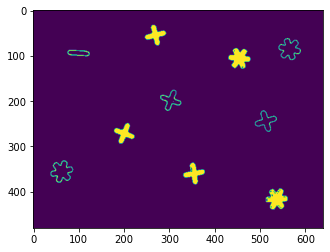

In [51]:
plt.imshow(regions.labels_.reshape(images[0][:,:,0].shape) == 2)

In [265]:
%timeit color_area2(images[0],K)

2.44 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<b>DISCUSSION</b>
<br>
##### General comment on method

##### Choice of params

##### Comment on results

##### Comparison to other methods

<i><b>WARNING</b></i>: <i> by double checking using k-means we see that roughly black pixels area are computed correctly using the first method. On blue pixels however (despite spilling over the black pixels) we are not yet clear, an issue is the transition from the color blue to background which is continuous enough to create a gap of value between the two methods. An idea was to use high pass filter, which we will implement soon. On top of which we notice that for either methods, the area of objects for the second image is always smaller than the other images -> this might be related histogram equalization not doing enough to normalize intensity </i>

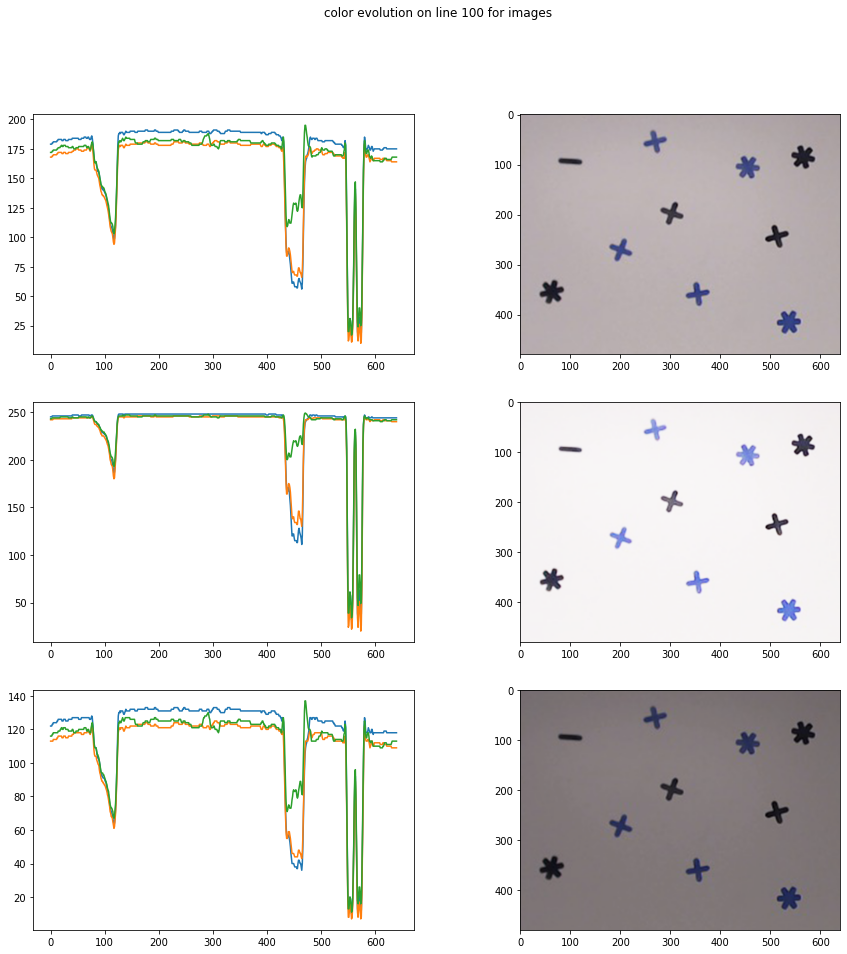

In [290]:
# just testing things below, ignore below
fig, ax = plt.subplots(3, 2,figsize=(15,15))
fig.suptitle('color evolution on line 100 for images')
ax[0,0].plot(images[0][100,])
ax[0,1].imshow(images[0])

ax[1,0].plot(images[1][100,])
ax[1,1].imshow(images[1])

ax[2,0].plot(images[2][100,])
ax[2,1].imshow(images[2])

plt.show()

# From graph -> potential issue around 400-500, we see gradual increase from blue to background

In [268]:
black_idx, blue_idx, back_idx = np.argsort(np.mean(regions.cluster_centers_,axis=1))
masks = regions.labels_.reshape(images[2].shape[:2])
blue_mask = (masks == blue_idx)
black_mask = (masks == black_idx)
background_mask = (masks == back_idx)

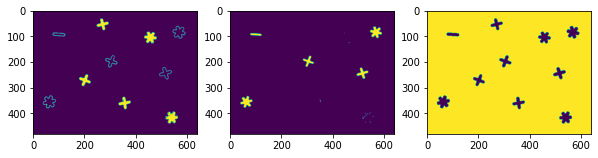

In [270]:
fig, ax = plt.subplots(1, 3,figsize=(10,10))
ax[0].imshow(blue_mask)
ax[1].imshow(black_mask)
ax[2].imshow(background_mask)
plt.show()

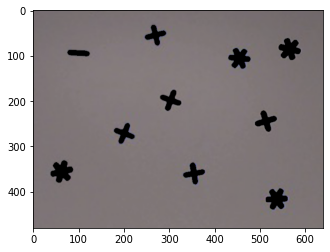

In [275]:
plt.imshow(np.stack((background_mask,)*3, axis=-1) * images[2])